In [3]:
import pandas as pd

# --- PART 1: LOAD DATA ---
print("1. Loading data... (Please wait, this takes about 60 seconds)")
df = pd.read_excel("Online Retail.xlsx")
print("   Data loaded successfully!")

# --- PART 2: CLEAN DATA ---
print("2. Cleaning data...")

# A. Drop rows where we don't know the CustomerID
df = df.dropna(subset=['CustomerID'])

# B. Remove rows where Quantity is 0 or less (returns/refunds)
df = df[df['Quantity'] > 0]

# C. Remove rows where Price is 0 or less (errors/freebies)
df = df[df['UnitPrice'] > 0]

# --- PART 3: VERIFY ---
print("3. Success! formatting complete.")
print("   Rows remaining:", len(df))
df.head()

1. Loading data... (Please wait, this takes about 60 seconds)
   Data loaded successfully!
2. Cleaning data...
3. Success! formatting complete.
   Rows remaining: 397884


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
import datetime as dt

# 1. Create a "Total_Price" column for each item
df['Total_Price'] = df['Quantity'] * df['UnitPrice']

# 2. Set the "Analysis Date" (1 day after the last purchase in the dataset)
current_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# 3. GROUP BY CustomerID to flatten the data
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (current_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                                 # Frequency
    'Total_Price': 'sum'                                    # Monetary
})

# 4. Rename columns
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Total_Price': 'Monetary'}, inplace=True)

# 5. Show the NEW table
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [5]:
# 1. Create labels for scoring
# Recency: Low days is BETTER, so we label 4, 3, 2, 1
r_labels = range(4, 0, -1) 
# Frequency/Monetary: High numbers are BETTER, so we label 1, 2, 3, 4
f_labels = range(1, 5)
m_labels = range(1, 5)

# 2. Divide into 4 equal groups (Quartiles)
# Note: We use .rank(method='first') to handle ties (e.g., many people buying just once)
rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), q=4, labels=r_labels)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), q=4, labels=m_labels)

# 3. Sum the scores to get a total (Max score = 12, Min score = 3)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].sum(axis=1)

print("Scoring complete!")
rfm.head()

Scoring complete!


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,4,6
12347.0,2,7,4310.00,4,4,4,12
12348.0,75,4,1797.24,2,3,4,9
12349.0,19,1,1757.55,3,1,4,8
12350.0,310,1,334.40,1,1,2,4


In [6]:
# Function to name the segments
def segment_customer(row):
    if row['RFM_Score'] >= 10:
        return 'Champions'       # Best customers
    elif row['RFM_Score'] >= 8:
        return 'Loyal Customers' # Good, steady
    elif row['RFM_Score'] >= 5:
        return 'Needs Attention' # Might leave soon
    else:
        return 'At Risk/Lost'    # Haven't seen them in a while

# Apply the function
rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

# Show the results
print(rfm['Customer_Segment'].value_counts())

Customer_Segment
Needs Attention    1427
Champions          1261
Loyal Customers     841
At Risk/Lost        809
Name: count, dtype: int64


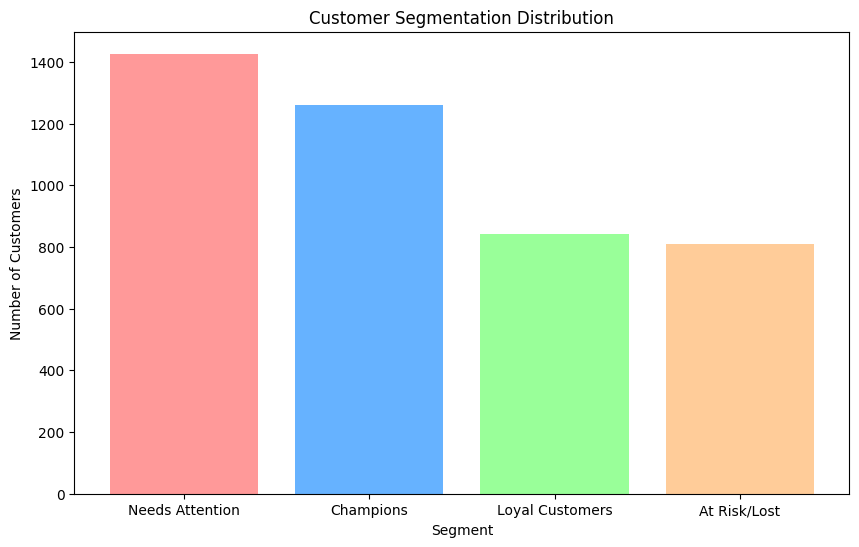

In [7]:
import matplotlib.pyplot as plt

# 1. Get the data (the list you just created)
segment_counts = rfm['Customer_Segment'].value_counts()

# 2. Create a bar chart
plt.figure(figsize=(10,6))
# We define colors: Red for bad, Blue/Green for good
colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99'] 

bars = plt.bar(segment_counts.index, segment_counts.values, color=colors)

# 3. Add labels so it looks professional
plt.title('Customer Segmentation Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')

# 4. Show the chart
plt.show()

In [13]:
# Install plotly if you haven't (run this once in a separate cell if needed)
# %pip install plotly

import plotly.express as px

# 1. Create an Interactive Bar Chart
fig = px.bar(
    x=segment_counts.index, 
    y=segment_counts.values,
    color=segment_counts.index,
    text=segment_counts.values,
    title="Customer Segmentation Analysis",
    labels={'x': 'Customer Segment', 'y': 'Number of Customers', 'color': 'Segment'},
    template="plotly_dark"  # Uses a sleek dark theme automatically
)

# 2. Customize the Layout (Make it look professional)
fig.update_layout(
    title_font_size=24,
    xaxis_title_font_size=14,
    yaxis_title_font_size=14,
    showlegend=False, 
    hovermode="x unified" # Cool hover effect
)

# 3. Optimize the Text Labels
fig.update_traces(
    textposition='outside', 
    marker_line_color='rgb(255,255,255)', 
    marker_line_width=1.5,
    opacity=0.9
)

# 4. Show the interactive chart
fig.show()

# 5. Save as an HTML file (You can open this in any browser!)
fig.write_html("interactive_segmentation.html")
print("Chart saved as 'interactive_segmentation.html'. Open that file in your browser to see the magic!")

Chart saved as 'interactive_segmentation.html'. Open that file in your browser to see the magic!


In [14]:
# 1. First, make sure we have the chart ready (from the previous step)
# (If fig is already defined, you don't need to change anything here)
import plotly.express as px

# Re-creating the figure just in case
fig = px.bar(
    x=segment_counts.index, 
    y=segment_counts.values,
    color=segment_counts.index,
    text=segment_counts.values,
    title="Customer Segmentation Analysis",
    template="plotly_dark"
)
fig.update_layout(showlegend=False)

# 2. Convert the chart to an HTML string (instead of saving it immediately)
# 'full_html=False' means we just want the chart code, not a whole empty page
chart_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

# 3. Create a professional HTML Report structure
report_html = f"""
<!DOCTYPE html>
<html>
<head>
    <title>Customer Segmentation Project</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 40px; background-color: #1e1e1e; color: #ffffff; }}
        .container {{ max-width: 1000px; margin: auto; }}
        h1 {{ color: #4facfe; }}
        p {{ line-height: 1.6; font-size: 18px; }}
        .card {{ background-color: #2d2d2d; padding: 20px; border-radius: 10px; margin-top: 20px; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>📊 Customer Segmentation Report</h1>
        <p>
            <strong>Project Overview:</strong> I analyzed transaction data from a UK Retailer to group customers 
            based on their purchasing behavior (RFM Analysis).
        </p>
        
        <div class="card">
            <h3>Key Insights:</h3>
            <ul>
                <li><strong>Champions ({segment_counts.get('Champions', 0)}):</strong> High-value customers who buy often.</li>
                <li><strong>At Risk ({segment_counts.get('At Risk/Lost', 0)}):</strong> Customers who haven't purchased recently.</li>
            </ul>
        </div>

        <div class="card">
            {chart_html}
        </div>
        
        <p style="text-align: center; color: gray; margin-top: 20px;">
            Generated using Python & Plotly by [Your Name]
        </p>
    </div>
</body>
</html>
"""

# 4. Save this new, complete report
with open("Project_Report.html", "w", encoding="utf-8") as file:
    file.write(report_html)

print("Success! Open 'Project_Report.html' to see your full webpage.")

Success! Open 'Project_Report.html' to see your full webpage.


In [15]:
import plotly.express as px

# 1. Get the chart HTML (just in case)
chart_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

# 2. Define a "Key Metrics" section
# We calculate these from your data
total_customers = segment_counts.sum()
top_segment = segment_counts.idxmax()
top_count = segment_counts.max()

# 3. The Professional HTML Structure with CSS
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Customer Segmentation Dashboard</title>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600&display=swap" rel="stylesheet">
    <style>
        body {{
            background-color: #111111; /* Deep dark background */
            color: #e0e0e0;
            font-family: 'Inter', sans-serif;
            margin: 0;
            padding: 40px;
        }}
        .container {{
            max-width: 1100px;
            margin: 0 auto;
        }}
        .header {{
            text-align: center;
            margin-bottom: 40px;
        }}
        .header h1 {{
            color: #ffffff;
            font-size: 3em;
            margin: 0;
            background: -webkit-linear-gradient(#eee, #333);
            -webkit-background-clip: text;
        }}
        .header p {{
            color: #888;
            font-size: 1.2em;
        }}
        
        /* The Grid for Stats */
        .metrics-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
            gap: 20px;
            margin-bottom: 30px;
        }}
        .metric-card {{
            background-color: #1e1e1e;
            padding: 20px;
            border-radius: 12px;
            border: 1px solid #333;
            text-align: center;
            box-shadow: 0 4px 6px rgba(0,0,0,0.3);
            transition: transform 0.2s;
        }}
        .metric-card:hover {{
            transform: translateY(-5px);
            border-color: #4facfe;
        }}
        .metric-value {{
            font-size: 2em;
            font-weight: bold;
            color: #4facfe;
        }}
        .metric-label {{
            color: #aaa;
            font-size: 0.9em;
            text-transform: uppercase;
            letter-spacing: 1px;
        }}

        /* The Chart Container */
        .chart-container {{
            background-color: #1e1e1e;
            padding: 20px;
            border-radius: 15px;
            border: 1px solid #333;
            box-shadow: 0 10px 20px rgba(0,0,0,0.4);
        }}
        
        .footer {{
            text-align: center;
            margin-top: 50px;
            color: #555;
            font-size: 0.8em;
        }}
    </style>
</head>
<body>

    <div class="container">
        
        <div class="header">
            <h1>Customer Segmentation</h1>
            <p>RFM Analysis Dashboard | Q4 2024</p>
        </div>

        <div class="metrics-grid">
            <div class="metric-card">
                <div class="metric-value">{total_customers:,}</div>
                <div class="metric-label">Total Customers</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{top_segment}</div>
                <div class="metric-label">Largest Segment</div>
            </div>
            <div class="metric-card">
                <div class="metric-value">{top_count:,}</div>
                <div class="metric-label">Customers in Largest</div>
            </div>
        </div>

        <div class="chart-container">
            {chart_html}
        </div>

        <div class="footer">
            Generated using Python, Pandas & Plotly
        </div>
    </div>

</body>
</html>
"""

# 4. Save the file (Overwrite the old ugly one)
with open("Project_Report.html", "w", encoding="utf-8") as file:
    file.write(html_content)

print("✨ Professional Dashboard Generated!")
print("Open 'Project_Report.html' to see the new look.")

✨ Professional Dashboard Generated!
Open 'Project_Report.html' to see the new look.


In [16]:
import plotly.express as px
import pandas as pd

# --- 1. PREPARE THE DATA & TEXT LOGIC ---
# Get the chart ready again
fig = px.bar(
    x=segment_counts.index, 
    y=segment_counts.values,
    color=segment_counts.index,
    text=segment_counts.values,
    title="Customer Segmentation Analysis",
    template="plotly_dark",
    color_discrete_map={ # Custom professional colors
        'Champions': '#00CC96', 
        'Loyal Customers': '#636EFA',
        'Needs Attention': '#FFA15A',
        'At Risk/Lost': '#EF553B'
    }
)
fig.update_layout(
    showlegend=False,
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    margin=dict(t=50, l=20, r=20, b=20)
)

# Calculate Stats
total_customers = segment_counts.sum()
top_segment = segment_counts.idxmax()
top_count = segment_counts.max()

# Contextual Insight Logic: What does the top segment mean?
insight_text = ""
if top_segment == "Champions":
    insight_text = "Your best customers are the largest group. Focus on loyalty programs to keep them!"
elif top_segment == "Needs Attention":
    insight_text = "The largest group needs immediate re-engagement. Send discount campaigns now."
elif top_segment == "At Risk/Lost":
    insight_text = "A significant number of customers have churned. Investigate recent service issues."
else:
    insight_text = "Your customer base is balanced. Maintain current strategies."

# Get the chart HTML
chart_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

# --- 2. THE PROFESSIONAL HTML REPORT ---
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Customer Segmentation | Ganesh Sirvi</title>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;800&display=swap" rel="stylesheet">
    <style>
        :root {{
            --bg-color: #121212;
            --card-bg: #1e1e1e;
            --text-color: #e0e0e0;
            --accent-color: #636EFA;
        }}
        body {{
            background-color: var(--bg-color);
            color: var(--text-color);
            font-family: 'Inter', sans-serif;
            margin: 0;
            padding: 0;
            line-height: 1.6;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            padding: 40px 20px;
        }}
        
        /* HEADER */
        .header {{
            text-align: center;
            margin-bottom: 50px;
            border-bottom: 1px solid #333;
            padding-bottom: 20px;
        }}
        .header h1 {{
            font-size: 3.5rem;
            margin: 0;
            font-weight: 800;
            background: linear-gradient(90deg, #ffffff, #888888);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
        }}
        .header p {{
            color: #888;
            font-size: 1.2rem;
            margin-top: 10px;
        }}

        /* KEY METRICS GRID */
        .metrics-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 20px;
            margin-bottom: 40px;
        }}
        .metric-card {{
            background-color: var(--card-bg);
            padding: 25px;
            border-radius: 12px;
            border: 1px solid #333;
            text-align: center;
            transition: transform 0.2s, border-color 0.2s;
        }}
        .metric-card:hover {{
            transform: translateY(-5px);
            border-color: var(--accent-color);
        }}
        .metric-value {{
            font-size: 2.5rem;
            font-weight: 700;
            color: var(--accent-color);
            margin-bottom: 5px;
        }}
        .metric-label {{
            color: #aaa;
            font-size: 0.9rem;
            text-transform: uppercase;
            letter-spacing: 1px;
            font-weight: 600;
        }}
        .metric-subtext {{
            color: #666;
            font-size: 0.85rem;
            margin-top: 10px;
            font-style: italic;
        }}

        /* MAIN CONTENT AREA */
        .content-grid {{
            display: grid;
            grid-template-columns: 2fr 1fr; /* Chart takes 2/3, Info takes 1/3 */
            gap: 30px;
            margin-bottom: 40px;
        }}
        @media (max-width: 800px) {{
            .content-grid {{ grid-template-columns: 1fr; }} /* Stack on mobile */
        }}
        
        .chart-container {{
            background-color: var(--card-bg);
            padding: 20px;
            border-radius: 15px;
            border: 1px solid #333;
            box-shadow: 0 10px 30px rgba(0,0,0,0.5);
            min-height: 450px;
        }}
        
        .info-card {{
            background-color: var(--card-bg);
            padding: 30px;
            border-radius: 15px;
            border: 1px solid #333;
        }}
        .info-card h3 {{
            color: #fff;
            margin-top: 0;
            border-bottom: 1px solid #444;
            padding-bottom: 10px;
        }}
        .info-card ul {{
            padding

_IncompleteInputError: incomplete input (2257875288.py, line 47)

In [17]:
import plotly.express as px
import pandas as pd

# --- 1. PREPARE THE DATA & TEXT LOGIC ---
# Get the chart ready again
fig = px.bar(
    x=segment_counts.index, 
    y=segment_counts.values,
    color=segment_counts.index,
    text=segment_counts.values,
    title="Customer Segmentation Analysis",
    template="plotly_dark",
    color_discrete_map={ # Custom professional colors
        'Champions': '#00CC96', 
        'Loyal Customers': '#636EFA',
        'Needs Attention': '#FFA15A',
        'At Risk/Lost': '#EF553B'
    }
)
fig.update_layout(
    showlegend=False,
    plot_bgcolor="rgba(0,0,0,0)",
    paper_bgcolor="rgba(0,0,0,0)",
    margin=dict(t=50, l=20, r=20, b=20)
)

# Calculate Stats
total_customers = segment_counts.sum()
top_segment = segment_counts.idxmax()
top_count = segment_counts.max()

# Contextual Insight Logic: What does the top segment mean?
insight_text = ""
if top_segment == "Champions":
    insight_text = "Your best customers are the largest group. Focus on loyalty programs to keep them!"
elif top_segment == "Needs Attention":
    insight_text = "The largest group needs immediate re-engagement. Send discount campaigns now."
elif top_segment == "At Risk/Lost":
    insight_text = "A significant number of customers have churned. Investigate recent service issues."
else:
    insight_text = "Your customer base is balanced. Maintain current strategies."

# Get the chart HTML
chart_html = fig.to_html(full_html=False, include_plotlyjs='cdn')

# --- 2. THE PROFESSIONAL HTML REPORT ---
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Customer Segmentation | Ganesh Sirvi</title>
    <link href="https://fonts.googleapis.com/css2?family=Inter:wght@300;400;600;800&display=swap" rel="stylesheet">
    <style>
        :root {{
            --bg-color: #121212;
            --card-bg: #1e1e1e;
            --text-color: #e0e0e0;
            --accent-color: #636EFA;
        }}
        body {{
            background-color: var(--bg-color);
            color: var(--text-color);
            font-family: 'Inter', sans-serif;
            margin: 0;
            padding: 0;
            line-height: 1.6;
        }}
        .container {{
            max-width: 1200px;
            margin: 0 auto;
            padding: 40px 20px;
        }}
        
        /* HEADER */
        .header {{
            text-align: center;
            margin-bottom: 50px;
            border-bottom: 1px solid #333;
            padding-bottom: 20px;
        }}
        .header h1 {{
            font-size: 3.5rem;
            margin: 0;
            font-weight: 800;
            background: linear-gradient(90deg, #ffffff, #888888);
            -webkit-background-clip: text;
            -webkit-text-fill-color: transparent;
        }}
        .header p {{
            color: #888;
            font-size: 1.2rem;
            margin-top: 10px;
        }}

        /* KEY METRICS GRID */
        .metrics-grid {{
            display: grid;
            grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
            gap: 20px;
            margin-bottom: 40px;
        }}
        .metric-card {{
            background-color: var(--card-bg);
            padding: 25px;
            border-radius: 12px;
            border: 1px solid #333;
            text-align: center;
            transition: transform 0.2s, border-color 0.2s;
        }}
        .metric-card:hover {{
            transform: translateY(-5px);
            border-color: var(--accent-color);
        }}
        .metric-value {{
            font-size: 2.5rem;
            font-weight: 700;
            color: var(--accent-color);
            margin-bottom: 5px;
        }}
        .metric-label {{
            color: #aaa;
            font-size: 0.9rem;
            text-transform: uppercase;
            letter-spacing: 1px;
            font-weight: 600;
        }}
        .metric-subtext {{
            color: #666;
            font-size: 0.85rem;
            margin-top: 10px;
            font-style: italic;
        }}

        /* MAIN CONTENT AREA */
        .content-grid {{
            display: grid;
            grid-template-columns: 2fr 1fr; /* Chart takes 2/3, Info takes 1/3 */
            gap: 30px;
            margin-bottom: 40px;
        }}
        @media (max-width: 800px) {{
            .content-grid {{ grid-template-columns: 1fr; }} /* Stack on mobile */
        }}
        
        .chart-container {{
            background-color: var(--card-bg);
            padding: 20px;
            border-radius: 15px;
            border: 1px solid #333;
            box-shadow: 0 10px 30px rgba(0,0,0,0.5);
            min-height: 450px;
        }}
        
        .info-card {{
            background-color: var(--card-bg);
            padding: 30px;
            border-radius: 15px;
            border: 1px solid #333;
        }}
        .info-card h3 {{
            color: #fff;
            margin-top: 0;
            border-bottom: 1px solid #444;
            padding-bottom: 10px;
        }}
        .info-card ul {{
            padding-left: 20px;
            color: #ccc;
        }}
        .info-card li {{
            margin-bottom: 10px;
        }}

        /* FOOTER */
        .footer {{
            text-align: center;
            margin-top: 60px;
            padding-top: 20px;
            border-top: 1px solid #333;
            color: #555;
            font-size: 0.9rem;
        }}
        .footer span {{
            color: var(--accent-color);
            font-weight: bold;
        }}
    </style>
</head>
<body>

    <div class="container">
        
        <div class="header">
            <h1>Customer Segmentation Dashboard</h1>
            <p>Automated RFM Analysis Report</p>
        </div>

        <div class="metrics-grid">
            <div class="metric-card">
                <div class="metric-value">{total_customers:,}</div>
                <div class="metric-label">Total Unique Customers</div>
                <div class="metric-subtext">Active Database Size</div>
            </div>
            
            <div class="metric-card">
                <div class="metric-value">{top_segment}</div>
                <div class="metric-label">Largest Customer Segment</div>
                <div class="metric-subtext">{insight_text}</div>
            </div>

            <div class="metric-card">
                <div class="metric-value">{top_count:,}</div>
                <div class="metric-label">Customers in Largest Group</div>
                <div class="metric-subtext">{(top_count/total_customers*100):.1f}% of total customer base</div>
            </div>
        </div>

        <div class="content-grid">
            
            <div class="chart-container">
                {chart_html}
            </div>

            <div class="info-card">
                <h3>About This Project</h3>
                <p>This dashboard visualizes customer behavior using <strong>RFM Analysis</strong> (Recency, Frequency, Monetary value). I processed raw transaction data using Python to segment users into actionable cohorts.</p>
                
                <h3>Methodology</h3>
                <ul>
                    <li><strong>Step 1:</strong> Data Cleaning (Removed returns & null IDs).</li>
                    <li><strong>Step 2:</strong> RFM Calculation (Grouped by CustomerID).</li>
                    <li><strong>Step 3:</strong> Scoring (Quartile ranking 1-4).</li>
                    <li><strong>Step 4:</strong> Segmentation (Logic-based grouping).</li>
                </ul>

                <h3>Strategic Recommendations</h3>
                <p><strong>For "Needs Attention":</strong> These customers buy often but haven't visited recently. Send them a "We Miss You" coupon immediately.</p>
                <p><strong>For "Champions":</strong> Reward them with early access to new products to maintain loyalty.</p>
            </div>
        </div>

        <div class="footer">
            Generated using <strong>Python, Pandas & Plotly</strong> by <span>Ganesh Sirvi</span>
        </div>
    </div>

</body>
</html>
"""

# Save it
with open("Project_Report.html", "w", encoding="utf-8") as file:
    file.write(html_content)

print("✅ Updated! Open 'Project_Report.html' to see the contextual insights and full layout.")

✅ Updated! Open 'Project_Report.html' to see the contextual insights and full layout.
